# Examples of ordinary differential equation discovery with EPDE framework

This notebook presents an overview of the evolutionary discovery of ODE on examples... 

In [1]:
import numpy as np
import os
import sys
from typing import Union, Callable

import matplotlib.pyplot as plt
import matplotlib as mpl

ADD SOME LINK TO ARTICLE ON EPDE PRINCIPLES

In [2]:
import sys
sys.path.append('..')
import helpers

In [3]:
import epde

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['text.usetex'] = True

SMALL_SIZE = 12
mpl.rc('font', size=SMALL_SIZE)
mpl.rc('axes', titlesize=SMALL_SIZE)

## First order ODE with trigonometric functions

Principles of equation discovery can be illustrated by a simple example of reconstruction of first-order equation:

\begin{equation}
\label{eq:ODE1}
x \sin{t} + \frac{d x}{d t} \cos{t} = 1,
\end{equation}

where the general solution for an arbitrary constant $C$ is:

\begin{equation}
\label{eq:ODE1_solution}
x = \sin{t} + C \cos{t}.
\end{equation}

To generate the data we will use an analytical particular solution, matching initial condition of $x(0) = 1.3$ (thus, $C = 1.3$) on the interval of $(0, 4 \pi)$:

\begin{equation}
\label{eq:ODE1_part_solution}
x = \sin{t} + 1.3 \cos{t}.
\end{equation}

Furthermore, we will provide an example of using a priori known derivatvies, that can be easily calculated by differentiating the solution:

\begin{equation}
\label{eq:ODE1_deriv_solution}
x' = \cos{t} - 1.3 \sin{t}.
\end{equation}

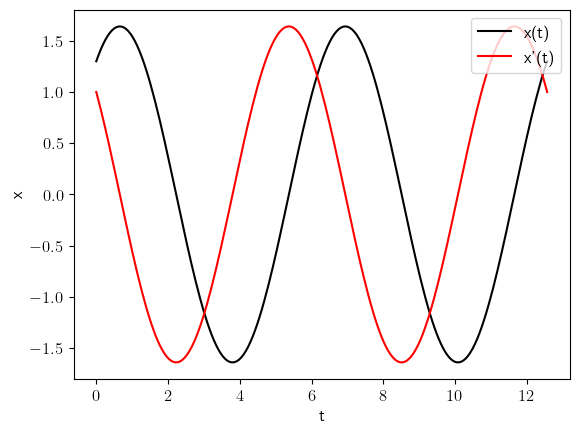

In [4]:
C = 1.3
t = np.linspace(0, 4*np.pi, 200)
x = np.sin(t) + C * np.cos(t)
x_dot = np.cos(t) - C * np.sin(t)

max_axis_idx = x.ndim - 1

plt.plot(t, x, color = 'k', label = 'x(t)')
plt.plot(t, x_dot, color = 'r', label = "x'(t)")

plt.legend(loc = 'upper right')
plt.xlabel('t')
plt.ylabel('x')
plt.show()

Next, we shall initialize the equation search object. Here we are using multiobjective optimization (here, it i denoted explicitly, despite it being the default option). Non-defalut parameter is the size of the boundary: $s_{bnd} = 20$.

Additional parameters will be as follows  population size number of optimziation epochs: ``n_epochs = 30``.

To be able to discovery the correct governing equation, the set of elementary functions (i.e. tokens) (in addition to the derivatives, that are always used) has to include the trigonometric functions. Furthermore, we will include grid as elementary block to provide diversity of the tokens.

In [5]:
bnd = 20
n_epochs = 60
popsize = 8

epde_search_obj = epde.EpdeSearch(multiobjective_mode = True, boundary = bnd, 
                                  dimensionality = max_axis_idx, coordinate_tensors = [t,], 
                                  verbose_params = {'show_iter_idx' : False}) # False for brevity

trig_tokens = epde.TrigonometricTokens(freq = (0.95, 1.05), dimensionality=max_axis_idx)
grid_tokens = epde.GridTokens(['x_0',], dimensionality = max_axis_idx, max_power = 7)

epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=n_epochs)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f9e1156f490>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f9e1156f490>
trig_token_params: VALUES = (0, 0)


The detection of differential equations is initiated with ``EpdeSearch.fit()`` method. Data is passed in the ``data`` argument, where the elements of the argument list are numpy.ndarrays, describing individual variables. The derivatives can be passed explicity in the argument ``derivs`` with the same logic: the argument has to be a list with numpy.ndarrays of derivatives for each variable. The dimensionality of such arrays has to be $n\_points \; \times \; deriv\_ords$, where $n\_points$ is the total number of points in the domain, and $deriv\_ords$ is the number of passed derivatives. With ``derivs = None``, the derivatives are calculated numerically.

Additional elementary functions, that we expect to have in the resulting equations, are passed in the ``additional_tokens`` argument. 

We define equation structure properties with the following settings:

- Argument ``max_deriv_order`` sets the highest order of derivatives, that can be used in equation search. 
- Number of terms, accepted into the structure before regularization is regulated by argument ``equation_terms_max_number``.
- Argument ``equation_factors_max_number`` defined number of terms in the term can be set as integer (in this case, the number of factors for the particular term is selected from a uniform distribution $U(1, equation\_factors\_max\_number)$), or by dictionary, as in our example.
- Argument ``data_fun_pow`` indicates the highest power of derivative-like token in the equation. With ``data_fun_pow = 2``, supported by sufficiently high ``equation_factors_max_number`` and ``equation_terms_max_number``, the terms like $u^2 u'$ and $(u')^2 \cdot u^2$ can appear in the equation, while terms like $u^3$ won't be allowed in structures.
- Sparsity constant range ``eq_sparsity_interval`` controls the complexities of the initially created candidate equations: the argument has to be a tuple of $(a_{left}, a_{right})$. Each candidate during the population initialization is given a value $\lambda = \exp{l}; \; l \sim U(\ln a_{left}, \ln a_{right})$. With the boundaries shifted to 0, the equation is regularized less, while with high values of $ a_{left} \; \& \; a_{right}$ the majority of terms will be filtered out.

In [6]:
factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.65, 0.35]} # 1 factor with P = 0.65, 2 with P = 0.35

epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(1,), derivs=[x_dot.reshape((-1, 1)),],
                    equation_terms_max_number=4, data_fun_pow = 1,
                    additional_tokens=[trig_tokens, grid_tokens],
                    equation_factors_max_number=factors_max_number,
                    eq_sparsity_interval=(1e-6, 1e-2))

Deriv orders after definition [[0]]
initial_shape (200,) derivs_tensor.shape (200, 1)
self.tokens is ['du/dx0']
Here, derivs order is {'du/dx0': [0]}
self.tokens is ['u']
Here, derivs order is {'u': [None]}
The cardinality of defined token pool is [1 1 2 1]
Among them, the pool contains [1 1 1]
self.vars_demand_equation {'u'}
Creating new equation, sparsity value [2.36734165e-05]
New solution accepted, confirmed 1/8 solutions.
Creating new equation, sparsity value [8.62020724e-05]
New solution accepted, confirmed 2/8 solutions.
Creating new equation, sparsity value [0.00013805]
New solution accepted, confirmed 3/8 solutions.
Creating new equation, sparsity value [0.00239122]
New solution accepted, confirmed 4/8 solutions.
Creating new equation, sparsity value [7.32697683e-05]
New solution accepted, confirmed 5/8 solutions.
Creating new equation, sparsity value [4.39302744e-06]
New solution accepted, confirmed 6/8 solutions.
Creating new equation, sparsity value [1.18893517e-06]
New sol

In [7]:
epde_search_obj.cache[1].memory_structural.keys()

dict_keys([('du/dx0', (1.0,)), ('u', (1.0,)), ('cos', (1.0, 1.0030272715624406, 0.0)), ('x_0', (7.0, 0.0)), ('sin', (1.0, 1.0203148814110738, 0.0)), ('x_0', (3.0, 0.0)), ('x_0', (6.0, 0.0)), ('cos', (1.0, 1.0201841853020892, 0.0)), ('x_0', (1.0, 0.0)), ('x_0', (4.0, 0.0)), ('cos', (1.0, 0.994609832632559, 0.0)), ('x_0', (5.0, 0.0)), ('cos', (1.0, 1.0018547474585378, 0.0)), (('du/dx0', (1.0,)), ('u', (1.0,))), ('sin', (1.0, 0.9502377788941707, 0.0)), ('cos', (1.0, 0.967199563164936, 0.0)), ('cos', (1.0, 1.0294090820747797, 0.0)), ('x_0', (2.0, 0.0)), ('sin', (1.0, 0.9942089067035561, 0.0)), ('sin', (1.0, 1.015122939121206, 0.0)), ('cos', (1.0, 1.004272628611352, 0.0)), ('sin', (1.0, 0.9688262357563594, 0.0)), ('cos', (1.0, 0.950074317655449, 0.0)), ('sin', (1.0, 1.00894776781194, 0.0)), ('sin', (1.0, 1.048890974454779, 0.0)), ('cos', (1.0, 0.9666129680043483, 0.0)), ('cos', (1.0, 0.9921305580210042, 0.0)), ('cos', (1.0, 0.9813583377080556, 0.0)), ('sin', (1.0, 0.9837287690143157, 0.0)),

The discovered equations can be accessed with ``EpdeSearch.equations()`` method. If the ``only_print = True``, than the equations will be printed in their text forms. 

Otherwise, they will be return: if the followup argument ``only_str`` is ``True``, than the equations are returned only in their symbolic string-form. If ``only_str = False``, than the equation in its program implementation ``epde.structure.main_structures.SoEq`` are returned.

In [ ]:
res = epde_search_obj.equations(False)

In [ ]:
res[0][0].vals['u'].structure[0].structure[0]._evaluator

In [ ]:
epde_search_obj.equations(only_print=True, num = 3)

The particular solution of the ODE in addition to the governing equation $x \sin{(t)} + x' \cos{(t)} = 1,$ also matches the solution of equation $x' \sin{(t)}  - x \cos{(t)} = - 1.3$. With them having (in ideal case) the same fitness functions values, we can expect presence of at least one type of such results in the equation.

We can use visual analysis of the Pareto-optimal set of candidate equations, placed in the complexity-quality criteria space, to select the optimal equation. Method ``EpdeSearch.visualize_solutions()`` illustrates the first non-dominated set of solutions (i.e. Pareto frontier). With its help we can see, that equations like $x' \cdot \sin{(1.001 \; t)} = 9.997\cdot 10^{-1} x \cdot cos{(1.006 \; t)} + -1.274$ (may differ due to stochastic nature of evolutionary optimization) matches the knee point of a Pareto frontier curve. *Note* In some cases, only two equations are discovered, or if multiple simple equations are proposed, thus no knee point analysis.

In [ ]:
epde_search_obj.visualize_solutions()

## Second order non-linear ODE

A more complex example of the problem can be posed by a linear non-homogeneous equation $x'' + \sin{(2t)} x' + 4 x = 1.5 t$. To get a synthetic dataset we can solve it with Runge-Kutta fourth order method. The particular solution matches the initial problem of $x|_{t = 0} = 0.8$, $x''|_{t = 0} = 2.0$ for domain $t \in [0, 16)$.

In [4]:
def second_order_lODE_by_RK(initial : tuple, timestep : float, steps : int, g1 : Callable, 
                           g2 : Callable, g3 : Callable, g4 : Callable):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        t = step*timestep
        k1 = res[step, 1] ; x1 = res[step, 0] + timestep/2. * k1
        l1 = (g4(t) - g3(t)*res[step, 0] - g2(t)*res[step, 1]) / g1(t); y1 = res[step, 1] + timestep/2. * l1

        k2 = y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = (g4(t) - g3(t)*x1 - g2(t)*y1) / g1(t); y2 = res[step, 1] + timestep/2. * l2

        k3 = y2
        l3 = (g4(t) - g3(t)*x2 - g2(t)*y2) / g1(t);
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = y3
        l4 = (g4(t) - g3(t)*x3 - g2(t)*y3) / g1(t)
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

In [5]:
g1 = lambda x: 1.
g2 = lambda x: np.sin(2*x)
g3 = lambda x: 4.
g4 = lambda x: 1.5*x

step = 0.05; steps_num = 320
t = np.arange(start = 0., stop = step * steps_num, step = step)
solution = second_order_lODE_by_RK(initial=(0.8, 2.), timestep=step, steps=steps_num, 
                                  g1=g1, g2=g2, g3=g3, g4=g4)

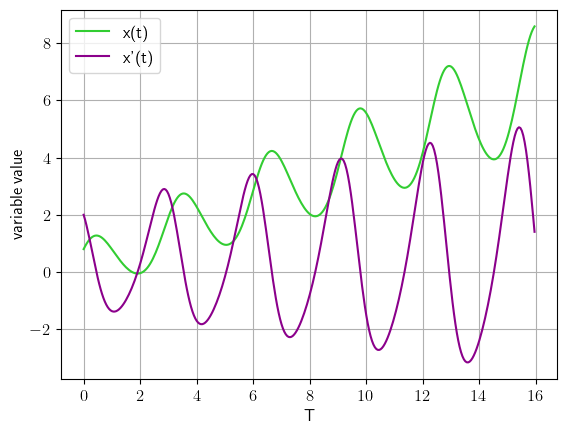

In [6]:
plt.plot(t, solution[:, 0], label = 'x(t)', color = 'limegreen')
plt.plot(t, solution[:, 1], label = "x'(t)", color = 'darkmagenta')
plt.grid(); plt.legend()
plt.xlabel('T'); plt.ylabel('variable value')
plt.show()

While it can be insightful to analyze the process with the data-driven differential equation, occasionally it will be needed to predict the future state of the system, based on the equation. In this experiment we will split the input dataset into train ($t \in [0, 8)$) and test ($t \in [8, 16)$) parts. To validate the predicitive ability, the best equation will be integrated over the domain, using internal automaitic differential equation solution methods.

In [7]:
def epde_discovery(t, x, use_ann = False):
    dimensionality = x.ndim - 1
    

    epde_search_obj = epde.EpdeSearch(use_solver = False, dimensionality = dimensionality, boundary = 30,
                                      coordinate_tensors = [t,], verbose_params = {'show_iter_idx' : False})
    if use_ann:
        epde_search_obj.set_preprocessor(default_preprocessor_type='ANN',
                                         preprocessor_kwargs={'epochs_max' : 50000})
    else:
        epde_search_obj.set_preprocessor(default_preprocessor_type='poly',
                                         preprocessor_kwargs={'use_smoothing' : False, 'sigma' : 1, 
                                                              'polynomial_window' : 3, 'poly_order' : 3}) 

    eps = 5e-7
    popsize = 10
    epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=55)
    trig_tokens = epde.TrigonometricTokens(freq = (2 - eps, 2 + eps), 
                                      dimensionality = dimensionality)
    factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.65, 0.35]}

    custom_grid_tokens = epde.GridTokens(dimensionality = dimensionality, max_power=1)
    
    epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(2,),
                        equation_terms_max_number=6, data_fun_pow = 1, 
                        additional_tokens=[trig_tokens, custom_grid_tokens], 
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=(1e-6, 1e-2))

    epde_search_obj.equations(only_print = True, num = 1)
    
    '''
    Having insight about the initial ODE structure, we are extracting the equation with complexity of 5
    
    In other cases, you should call epde_search_obj.equations(only_print = True), or epde_search_obj.
    where the algorithm presents Pareto frontier of optimal equations.
    '''

    return epde_search_obj

In [8]:
t_max = 160
t_train = t[:t_max]; t_test = t[t_max:] 
x_train = solution[:t_max, 0]; x_test = solution[t_max:, 0]

epde_search_obj = epde_discovery(t_train, x_train, True)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f02c3a32e20>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f02c3a32e20>
trig_token_params: VALUES = (0, 0)
Deriv orders after definition [[0], [0, 0]]
initial_shape (160,) derivs_tensor.shape (160, 2)
self.tokens is ['du/dx0', 'd^2u/dx0^2']
Here, derivs order is {'du/dx0': [0], 'd^2u/dx0^2': [0, 0]}
self.tokens is ['u']
Here, derivs order is {'u': [None]}
The cardinality of defined token pool is [1 2 2 1]
Among them, the pool contains [1 2 1]
self.vars_demand_equation {'u'}
Creating new equation, sparsity value [0.00052133]
New solution accepted, confirmed 1/10 solutions.
Creating new equation, sparsity value [0.00781528]
New solution accepted, confirmed 2/10 solutions.
Creating new equation, sparsity value [4.37420099e-05]
New solution accepted, confirmed 3/10 solutions.
Creating new equation, sparsity value [0.00033717]
New solution accepted, confirmed 4/10 solutions.
Creating new 

$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot sin^{1.0}(2.0 x_{0.0}) = -9.911\cdot 10^{-1} \frac{\partial ^2u}{\partial x_0^2} + 1.483t + -3.931u + -6.163\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} = -2.121\cdot 10^{-1} t + 2.041\cdot 10^{-1} u + -1.062u \cdot sin^{1.0}(2.0 x_{0.0}) + 3.291\cdot 10^{-1} t \cdot cos^{1.0}(2.0 x_{0.0}) + 1.295 \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot sin^{1.0}(2.0 x_{0.0}) = 1.411t + -6.545\cdot 10^{-2} \frac{\partial u}{\partial x_0} + -9.908\cdot 10^{-1} \frac{\partial ^2u}{\partial x_0^2} + -1.404\cdot 10^{-1} u \cdot sin^{1.0}(2.0 x_{0.0}) + -3.802u + 8.088\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = 1.494t + -9.876\cdot 10^{-1} \frac{\partial u}{\partial x_0} \cdot sin^{1.0}(2.0 x_{0.0}) + -3.973u + 3.336\cdot 10^{-3} \frac{\partial u}{\partial x_0} \cdot t + -3.45\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\par

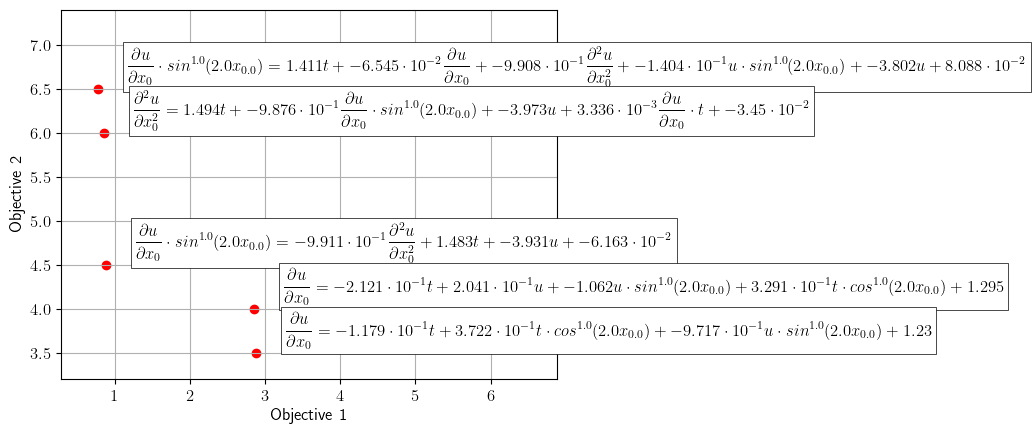

In [9]:
epde_search_obj.visualize_solutions()

In [12]:
sys = epde_search_obj.get_equations_by_complexity(4.5)[0]

In [13]:
sys.text_form

"-0.9911272435338928 * d^2u/dx0^2{power: 1.0} + 1.4833584601129806 * t{power: 1.0, dim: 0.0} + -3.931232649557504 * u{power: 1.0} + 0.0 * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * t{power: 1.0, dim: 0.0} + -0.06163107040010207 = du/dx0{power: 1.0} * sin{power: 1.0, freq: 1.9999995805494022, dim: 0.0}\n{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.0036484916935764678}}"

While there are multiple equations on the Pareto frontier, we can establish two candidates for the knee-points (for brevity they are denoted by their complexities: 4 and 4.5). The further increase in complexity does not provide significant error decrease, thus is not necessary. We shall analyze the process representation quality on the test dataset by solving initial value problem.

The equation with complexity of 4.5 is second-order, thus to solve it we need the function value and the solution derivatve

In [14]:
import torch
from epde.interface.solver_integration import BoundaryConditions, BOPElement

eq_1 = epde_search_obj.get_equations_by_complexity(4.5)[0]
print(eq_1.text_form)

-0.9911272435338928 * d^2u/dx0^2{power: 1.0} + 1.4833584601129806 * t{power: 1.0, dim: 0.0} + -3.931232649557504 * u{power: 1.0} + 0.0 * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * t{power: 1.0, dim: 0.0} + -0.06163107040010207 = du/dx0{power: 1.0} * sin{power: 1.0, freq: 1.9999995805494022, dim: 0.0}
{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.0036484916935764678}}


In [15]:
def get_ode_bop(key, var, term, grid_loc, value):
    bop = BOPElement(axis = 0, key = key, term = term, power = 1, var = var)
    bop_grd_np = np.array([[grid_loc,]])
    bop.set_grid(torch.from_numpy(bop_grd_np).type(torch.FloatTensor))
    bop.values = torch.from_numpy(np.array([[value,]])).float()
    return bop

bop_u = get_ode_bop('u', 0, [None], t_test[0], x_test[0])

# Set derivative with central finite difference
bop_du = get_ode_bop('dudt', 0, [0,], t_test[0], (x_test[1] - x_train[-1])/(2*(t_test[1] - t_test[0])))   

In [16]:
t_test.shape
t_test_oversampled = np.linspace(t_test[0], t_test[-1], 160)

In [35]:
eq_1.text_form

"-0.9911272435338928 * d^2u/dx0^2{power: 1.0} + 1.4833584601129806 * t{power: 1.0, dim: 0.0} + -3.931232649557504 * u{power: 1.0} + 0.0 * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * t{power: 1.0, dim: 0.0} + -0.06163107040010207 = du/dx0{power: 1.0} * sin{power: 1.0, freq: 1.9999995805494022, dim: 0.0}\n{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.0036484916935764678}}"

In [42]:
import time

In [50]:
t1 = time.time()
params_base = True
if params_base:
    pred_u = epde_search_obj.predict(system=eq_1, boundary_conditions = [bop_u(), bop_du()], # })
                                     grid = [t_test,], mode='autograd', use_fourier = True, fft_params = {'L' : [4,], 
                                                                                                    'M' : [3,]},
                                     compiling_params = {'tol' : 0.005})
else:
    pred_u = epde_search_obj.predict(system=eq_1, boundary_conditions = [bop_u(), bop_du()], # })
                                     grid = [t_test,], mode='mat', use_fourier = True,
                                     optimizer_params = {'optimizer' : 'LBFGS', 'params' : {'lr' : 5*1e-1}}, 
                                     compiling_params = {'tol' : 0.005, 'derivative_points' : 3}) # , 'eps' : 1e-8
t2 = time.time()
print(f'Learning time is {t2-t1}')

Using explicitly sent system of equations.
grid.shape is (160,)
target_form shape is torch.Size([160, 1])
[2024-04-09 16:17:54.243801] initial (min) loss is 311.5636291503906
Step = 10000 loss = 0.116328.
Step = 20000 loss = 0.005851.
[2024-04-09 16:22:39.921852] No improvement in 1000 steps
[2024-04-09 16:22:39.922211] Step = 24247 loss = 0.040508 normalized loss line= 0.000904x+0.514383. There was 1 stop dings already.
[2024-04-09 16:23:05.721156] No improvement in 1000 steps
[2024-04-09 16:23:05.721504] Step = 26506 loss = 0.040636 normalized loss line= -0.000539x+0.999152. There was 2 stop dings already.
[2024-04-09 16:23:20.210374] No improvement in 1000 steps
[2024-04-09 16:23:20.210696] Step = 27789 loss = 0.007846 normalized loss line= 0.002819x+3.391759. There was 3 stop dings already.
[2024-04-09 16:23:31.228979] No improvement in 1000 steps
[2024-04-09 16:23:31.229301] Step = 28789 loss = 0.010714 normalized loss line= 0.015156x+1.391637. There was 4 stop dings already.
Step

In [ ]:
692, 678, 225, 367

In [46]:
pred_u = pred_u.reshape(-1)

To evaluate the quality of obtained equation, we will check the MAPE error and visualize the solution oftest domain.

In [47]:
if isinstance(pred_u, torch.Tensor):
    pred_u = pred_u.detach().numpy()

In [48]:
pred_u.shape

(160,)

MAPE on the test dataset is 0.44727594525019143


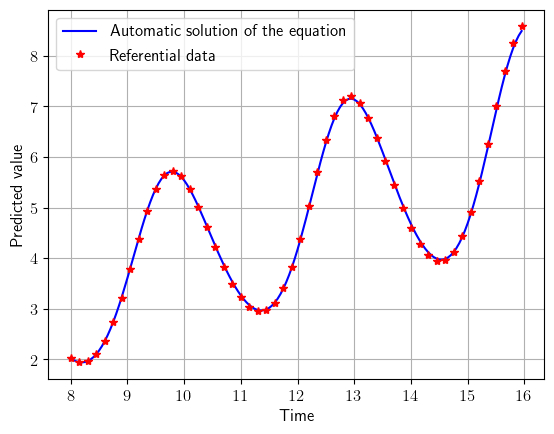

In [51]:
print(f'MAPE on the test dataset is {np.mean(np.abs((pred_u - x_test)/x_test))}')

plt.plot(t_test, pred_u, color = 'b', label = 'Automatic solution of the equation')
plt.plot(t_test[::3], x_test[::3], '*', color = 'r', label = 'Referential data')
plt.xlabel('Time'); plt.ylabel('Predicted value') 
plt.grid()
plt.legend()
plt.show()

In [23]:
eq2 = epde_search_obj.get_equations_by_complexity(4)[0]
eq2.text_form

"-0.20843339218331683 * t{power: 1.0, dim: 0.0} + 0.21276725930849572 * u{power: 1.0} + 0.3326086216429273 * t{power: 1.0, dim: 0.0} * cos{power: 1.0, freq: 1.9999996145821608, dim: 0.0} + -1.0672032632057837 * u{power: 1.0} * sin{power: 1.0, freq: 2.000000196298218, dim: 0.0} + 0.0 * u{power: 1.0} * cos{power: 1.0, freq: 2.0000002084422435, dim: 0.0} + 1.2672353920956567 = du/dx0{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.0011728486842368967}}"

This equation has the first order, thus only a single initial condition $u|_{t = t_{val, 0}}$ is needed, and we get it from the data.

In [22]:
bop_u = get_ode_bop('u', 0, [None], t_test[0], x_test[0])
pred_u = epde_search_obj.predict(system=eq2, 
                                 boundary_conditions = [bop_u(),],# bop_du()],
                                 grid = [t_test,], strategy='autograd')
pred_u = pred_u.reshape(-1)

Using explicitly sent system of equations.
dimensionality is 1
grid.shape is (160,)
Shape of the grid for solver torch.Size([160, 1])
Grid is  <class 'torch.Tensor'> torch.Size([160, 1])
torch.Size([1])
[2023-11-14 13:51:32.210840] initial (min) loss is 110.7210922241211
[2023-11-14 13:51:32.260130] Print every 1000 step
Step = 0 loss = 110.721092 normalized loss line= -0.000000x+1.000000. There was 1 stop dings already.
[2023-11-14 13:51:37.926107] No improvement in 100 steps
Step = 162 loss = 0.660284 normalized loss line= -1.009283x+69.538913. There was 1 stop dings already.
[2023-11-14 13:51:45.445565] No improvement in 100 steps
Step = 368 loss = 0.650706 normalized loss line= -0.000093x+1.004540. There was 2 stop dings already.
[2023-11-14 13:52:06.541110] Print every 1000 step
Step = 1000 loss = 0.383480 normalized loss line= -0.001463x+1.400814. There was 3 stop dings already.
[2023-11-14 13:52:37.372257] Print every 1000 step
Step = 2000 loss = 0.288431 normalized loss line= 0

MAPE on the test dataset is 1.7942529267020053


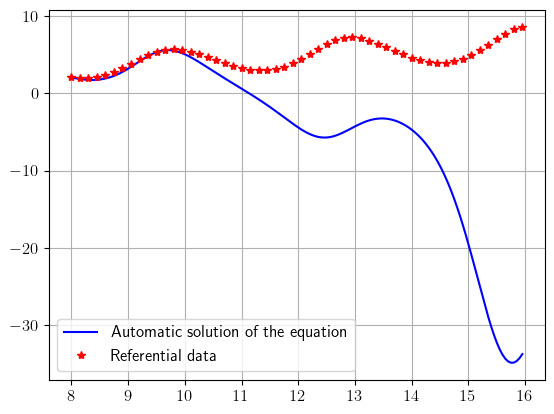

In [23]:
print(f'MAPE on the test dataset is {np.mean(np.abs((pred_u - x_test)/x_test))}')

plt.plot(t_test, pred_u, color = 'b', label = 'Automatic solution of the equation')
plt.plot(t_test[::3], x_test[::3], '*', color = 'r', label = 'Referential data')
plt.grid()
plt.legend()
plt.show()

In the result we can see, that the equation like $1.42 t - 3.81 u -0.96 u'' + 0.007 = u' \sin{(2.0 t)}$ can decently describe the process, while the alternative equation is not representative enough.

## Van der Pol oscillator

The problem of non-linear ordinary differential equations discovery can be demonstrated with the Van der Pol oscillator. Initially introduced to describe the relaxation-oscillation cycle produced by the electromagnetic field, the model has found applications in other spheres of science, such as biology or seismology. Its state is governed by equation $u'' + \mathcal{E}(u^2 - 1)u' + u = 0$, where $\mathcal{E}$ is a positive constant (in the example we will use $\mathcal{E} = 0.2$). To prepare synthetic dataset we will again use Runge-Kutta method:

In [35]:
def VdP_by_RK(initial: tuple, timestep: float, steps: int, epsilon: float):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        t = step*timestep
        k1 = res[step, 1] ; x1 = res[step, 0] + timestep/2. * k1
        l1 =  - epsilon*(res[step, 0]**2 - 1)*res[step, 1] - res[step, 0]; y1 = res[step, 1] + timestep/2. * l1

        k2 = y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = - epsilon*(x1**2 - 1)*y1 - x1; y2 = res[step, 1] + timestep/2. * l2

        k3 = y2
        l3 = - epsilon*(x2**2 - 1)*y2 - x2
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = y3
        l4 = - epsilon*(x3**2 - 1)*y3 - x3
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

def prepare_VdP_data(initial = (np.sqrt(3)/2., 1./2.), step = 0.05, steps_num = 640, epsilon = 0.2):
    t = np.arange(start = 0., stop = step * steps_num, step = step)
    solution = VdP_by_RK(initial=initial, timestep=step, steps=steps_num, 
                                      epsilon=epsilon)
    return t, solution

In [36]:
def epde_discovery_as_ode(t, x, use_ann:bool = False):
    dimensionality = x.ndim - 1
    epde_search_obj = epde.EpdeSearch(use_solver = False, dimensionality = dimensionality, boundary = 50,
                                           coordinate_tensors = [t,], verbose_params = {'show_iter_idx' : False})
    if use_ann:
        epde_search_obj.set_preprocessor(default_preprocessor_type='ANN',
                                         preprocessor_kwargs={'epochs_max' : 35000})
    else:
        epde_search_obj.set_preprocessor(default_preprocessor_type='poly',
                                         preprocessor_kwargs={'use_smoothing' : True, 'sigma' : 1, 
                                                              'polynomial_window' : 15, 'poly_order' : 12})
    popsize = 12
    epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=125)
    
    factors_max_number = {'factors_num' : [1, 2, 3], 'probas' : [0.4, 0.3, 0.3]}
    
    epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(3,),
                        equation_terms_max_number=6, data_fun_pow = 2,
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=(1e-13, 1e0))
    
    epde_search_obj.equations(only_print = True, num = 1)
    
    return epde_search_obj

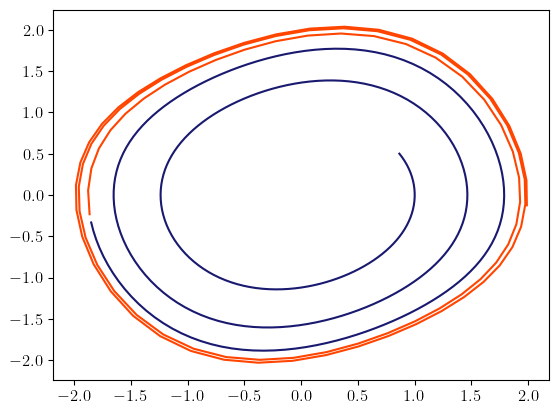

In [37]:
t, x_stacked = prepare_VdP_data()
t_max = 320
x, y = x_stacked[:, 0], x_stacked[:, 1]
t_train, t_test = t[:t_max], t[:t_max]
x_train, x_test = x[:t_max], x[t_max:]
y_train, y_test = y[:t_max], y[t_max:]
plt.plot(x_train, y_train, color = 'midnightblue')
plt.plot(x_test[::3], y_test[::3], color = 'orangered')
plt.show()

In [38]:
epde_search_obj = epde_discovery_as_ode(t_train, x_train, False)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fa2e7f9dfa0>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fa2e7f9dfa0>
Deriv orders after definition [[None], [0], [0, 0], [0, 0, 0]]
320
initial_shape (320,) derivs_tensor.shape (320, 3)
self.tokens is ['u', 'du/dx0', 'd^2u/dx0^2', 'd^3u/dx0^3']
Here, derivs order is {'u': [None], 'du/dx0': [0], 'd^2u/dx0^2': [0, 0], 'd^3u/dx0^3': [0, 0, 0]}
The cardinality of defined token pool is [4]
Among them, the pool contains [4]
Creating new equation, sparsity value [0.68407237]
New solution accepted, confirmed 1/12 solutions.
Creating new equation, sparsity value [5.07778797e-08]
New solution accepted, confirmed 2/12 solutions.
Creating new equation, sparsity value [2.64026735e-06]
New solution accepted, confirmed 3/12 solutions.
Creating new equation, sparsity value [2.57395265e-11]
New solution accepted, confirmed 4/12 solutions.
Creating new equation, sparsity value [6.03921139e-06]
New 

$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = -1.0u + -1.991\cdot 10^{-1} \left(u\right)^{2.0} \cdot \frac{\partial u}{\partial x_0} + 1.991\cdot 10^{-1} \frac{\partial u}{\partial x_0} + -1.264\cdot 10^{-5}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} \cdot u = -1.013\left(u\right)^{2.0} + 7.106\cdot 10^{-3}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = -1.007u + 1.034\cdot 10^{-2}  \end{eqnarray*}$


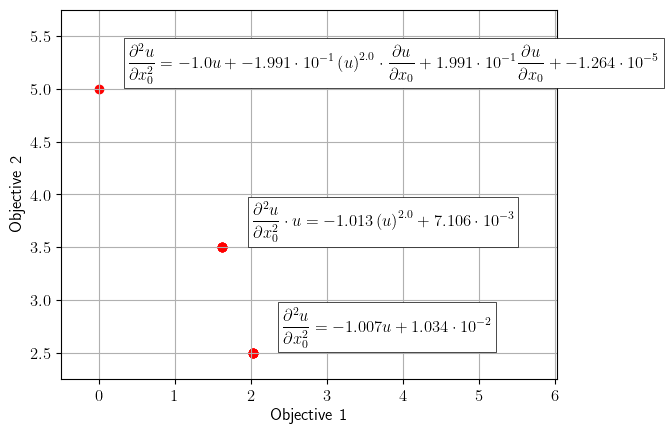

In [39]:
epde_search_obj.visualize_solutions()

Let's extract equations, that can be useful for system description: 

*Note*: during other example launches, the discovered equations may be different. To proceed, adopt getting equations by complexities, according to the Pareto frontier.

In [40]:
eq_compl_5 = epde_search_obj.get_equations_by_complexity(5)[0]
eq_compl_3_5 = epde_search_obj.get_equations_by_complexity(3.5)[0]
eq_compl_2_5 = epde_search_obj.get_equations_by_complexity(2.5)[0]

The Pareto frontier is concave, having the relatively simple yet very descriptive equation, matching the equation $u'' = -u + 0.2 u' - 0.2 u^2 u' + \delta$, $\delta << 1$ which we will consider as a useful equation-based model of the process.

Even though we already know, that it is very similar to the equation, from which we generated the data, we should still examine its predictive properties. Let's solve the equation with solver:

In [41]:
import torch
from epde.interface.solver_integration import BoundaryConditions, BOPElement

def get_ode_bop(key, var, term, grid_loc, value):
    bop = BOPElement(axis = 0, key = key, term = term, power = 1, var = var)
    bop_grd_np = np.array([[grid_loc,]])
    bop.set_grid(torch.from_numpy(bop_grd_np).type(torch.FloatTensor))
    bop.values = torch.from_numpy(np.array([[value,]])).float()
    return bop

In [14]:
bop_u = get_ode_bop('u', grid_loc = t_test[0], value = x_test[0], term = [None], var = 0)
bop_dudt = get_ode_bop('dudt', grid_loc = t_test[0], value = y_test[0], term = [0], var = 0)

#get solution for equation with complexity 5
pred_u_compl_5 = epde_search_obj.predict(system=eq_compl_5, boundary_conditions=[bop_u(), bop_dudt()], 
                                         grid = [t_test,], strategy='autograd')
pred_u_compl_5 = pred_u_compl_5.reshape(pred_u_compl_5.size)

#get solution for equation with complexity 3.5
pred_u_compl_3_5 = epde_search_obj.predict(system=eq_compl_3_5, boundary_conditions=[bop_u(), bop_dudt()], 
                                           grid = [t_test,], strategy='autograd')
pred_u_compl_3_5 = pred_u_compl_3_5.reshape(pred_u_compl_3_5.size)

#get solution for equation with complexity 7
pred_u_compl_2_5 = epde_search_obj.predict(system=eq_compl_2_5, boundary_conditions=[bop_u(), bop_dudt()], 
                                         grid = [t_test,], strategy='autograd')
pred_u_compl_2_5 = pred_u_compl_2_5.reshape(pred_u_compl_2_5.size)

Using explicitly sent system of equations.
dimensionality is 1
grid.shape is (320,)
Shape of the grid for solver torch.Size([320, 1])
Grid is  <class 'torch.Tensor'> torch.Size([320, 1])
torch.Size([1])
[2023-11-14 17:58:49.791355] initial (min) loss is 233.1897735595703
[2023-11-14 17:58:49.937425] Print every 1000 step
Step = 0 loss = 233.189774 normalized loss line= -0.000000x+1.000000. There was 1 stop dings already.
[2023-11-14 18:00:24.333874] Print every 1000 step
Step = 1000 loss = 0.000062 normalized loss line= -0.160467x+12.686782. There was 1 stop dings already.
[2023-11-14 18:01:10.814415] No improvement in 100 steps
Step = 1521 loss = 0.000237 normalized loss line= 0.049447x+-0.633838. There was 1 stop dings already.
[2023-11-14 18:01:27.991496] No improvement in 100 steps
Step = 1694 loss = 0.000027 normalized loss line= -0.316416x+22.806038. There was 2 stop dings already.
[2023-11-14 18:01:51.412303] No improvement in 100 steps
Step = 1922 loss = 0.000031 normalized los

MAPE on the test dataset for eq with $C = 3.5$ is 0.9981632434643799
MAPE on the test dataset for eq with $C = 5$ is 0.03557201854479851
MAPE on the test dataset for eq with $C = 4$ is 0.39093209717733757


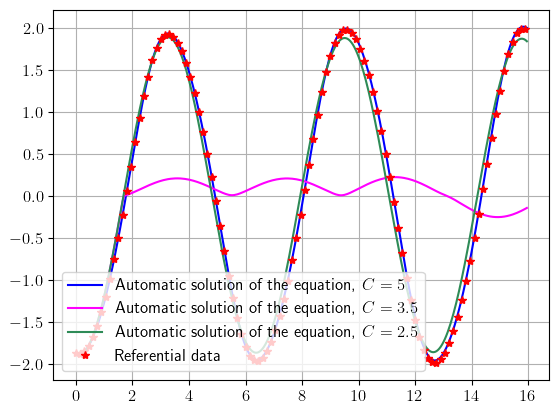

In [17]:
mae_compl_3_5 = np.mean(np.abs((pred_u_compl_3_5 - x_test)/x_test))
mae_compl_5 = np.mean(np.abs((pred_u_compl_5 - x_test)/x_test))
mae_compl_2_5 = np.mean(np.abs((pred_u_compl_2_5 - x_test)/x_test))

print(f'MAPE on the test dataset for eq with $C = 3.5$ is {mae_compl_3_5}')
print(f'MAPE on the test dataset for eq with $C = 5$ is {mae_compl_5}')
print(f'MAPE on the test dataset for eq with $C = 4$ is {mae_compl_2_5}')

plt.plot(t_test, pred_u_compl_5, color = 'b', label = 'Automatic solution of the equation, $C = 5$')
plt.plot(t_test, pred_u_compl_3_5, color = 'magenta', label = 'Automatic solution of the equation, $C = 3.5$')
plt.plot(t_test, pred_u_compl_2_5, color = 'seagreen', label = 'Automatic solution of the equation, $C = 2.5$')

plt.plot(t_test[::3], x_test[::3], '*', color = 'r', label = 'Referential data')
plt.grid()
plt.legend(loc = 'lower left')
plt.show()

Here, we can notice, that the "correct" governing equation, which closely matches the Van der Pol equation, has the lowest MAPE metric on the test dataset, even outperforming the equations with higher complexities. The equation with lower complexity can represent only the averaged values of the system. Thus, we can select the equation like $u'' = -u + 0.2 u' - 0.2 u^2 u' + \delta$ for system representation.

## Lotka-Volterra system

TO BE DONE

In [10]:
def Lotka_Volterra_by_RK(initial : tuple, timestep : float, steps : int, alpha : float, 
                         beta : float, delta : float, gamma : float):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        # print(res[step, :])
        k1 = alpha * res[step, 0] - beta * res[step, 0] * res[step, 1]; x1 = res[step, 0] + timestep/2. * k1
        l1 = delta * res[step, 0] * res[step, 1] - gamma * res[step, 1]; y1 = res[step, 1] + timestep/2. * l1

        k2 = alpha * x1 - beta * x1 * y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = delta * x1 * y1 - gamma * y1; y2 = res[step, 1] + timestep/2. * l2

        k3 = alpha * x2 - beta * x2 * y2
        l3 = delta * x2 * y2 - gamma * y1
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = alpha * x3 - beta * x3 * y3
        l4 = delta * x3 * y3 - gamma * y3
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

steps_num = 301; step = 1./steps_num
t = np.arange(start = 0, stop = step * steps_num, step = step)
solution = Lotka_Volterra_by_RK(initial=(4., 2.), timestep=step, steps=steps_num, 
                                alpha=20., beta=20., delta=20., gamma=20.)

In [15]:
def epde_discovery(t, x, y, use_ann = False):
    dimensionality = x.ndim - 1
    
    '''
    Подбираем Парето-множество систем дифф. уравнений.
    '''
    epde_search_obj = epde.EpdeSearch(use_solver = False, dimensionality = dimensionality, 
                                          boundary = 25, coordinate_tensors = [t,])
    
    if use_ann:
        epde_search_obj.set_preprocessor(default_preprocessor_type='ANN',
                                         preprocessor_kwargs={'epochs_max' : 25000})
    else:
        epde_search_obj.set_preprocessor(default_preprocessor_type='poly',
                                         preprocessor_kwargs={'use_smoothing' : True, 'sigma' : 1, 
                                                              'polynomial_window' : 3, 'poly_order' : 3})
    
    popsize = 20
    epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=30)

    factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.5, 0.5]}
    
    epde_search_obj.fit(data=[x, y], variable_names=['u', 'v'], max_deriv_order=(1,),
                        equation_terms_max_number=5, data_fun_pow = 2,
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=(1e-8, 1e-4))       
    return epde_search_obj

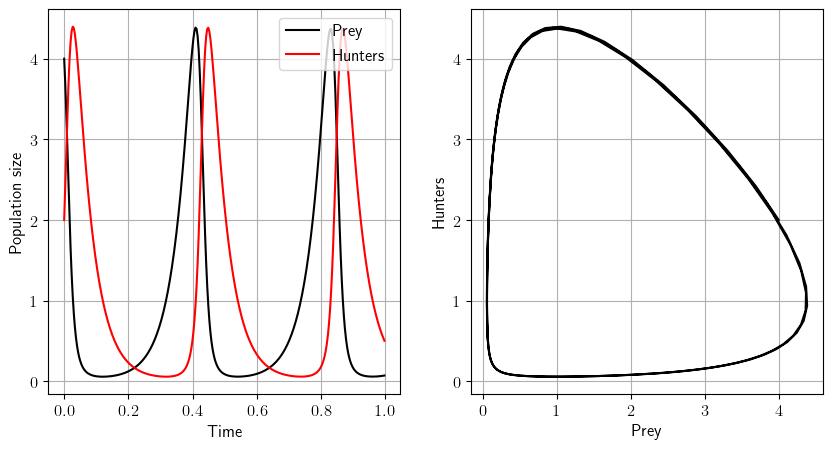

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.plot(t, solution[:, 0], color= 'k', label = 'Prey')
ax1.plot(t, solution[:, 1], color= 'r', label = 'Hunters')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population size')
ax1.legend(loc = 'upper right')
ax1.grid()

ax2.set_xlabel('Prey')
ax2.set_ylabel('Hunters')
ax2.plot(solution[:, 0], solution[:, 1], color= 'k')
ax2.grid()
plt.show()

In [17]:
t_max = 150
t_train = t[:t_max]; t_test = t[t_max:]

x = solution[:t_max, 0]; x_test = solution[t_max:, 0]
y = solution[:t_max, 1]; y_test = solution[t_max:, 1]

epde_search_obj = epde_discovery(t_train, x, y, False)
epde_search_obj.equations(only_print = True, num = 1)     

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f06b1ef60d0>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f06b1ef60d0>
Deriv orders after definition [[None], [0]]
150
initial_shape (150,) derivs_tensor.shape (150, 1)
self.tokens is ['u', 'du/dx0']
Here, derivs order is {'u': [None], 'du/dx0': [0]}
Deriv orders after definition [[None], [0]]
150
initial_shape (150,) derivs_tensor.shape (150, 1)
self.tokens is ['v', 'dv/dx0']
Here, derivs order is {'v': [None], 'dv/dx0': [0]}
The cardinality of defined token pool is [2 2]
Among them, the pool contains [2 2]
Creating new equation, sparsity value [1.60777933e-07 1.16300063e-06]
New solution accepted, confirmed 1/20 solutions.
Creating new equation, sparsity value [5.01694093e-08 1.56636522e-05]
New solution accepted, confirmed 2/20 solutions.
Creating new equation, sparsity value [2.57337456e-06 1.03269306e-07]
New solution accepted, confirmed 3/20 solutions.
Creating new equation, s

During MO : processing 14-th weight.
During MO : processing 15-th weight.
During MO : processing 16-th weight.
During MO : processing 17-th weight.
During MO : processing 18-th weight.
During MO : processing 19-th weight.
Multiobjective optimization : 7-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
During MO : processing 12-th weight.
During MO : processing 13-th weight.
During MO : processing 14-th weight.
During MO : processing 15-th weight.
During MO : processing 16-th weight.
During MO : processing 17-th weight.
During MO : processing 18-th weight.
During MO : processing 19-th weight.
Multio

During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
During MO : processing 12-th weight.
During MO : processing 13-th weight.
During MO : processing 14-th weight.
During MO : processing 15-th weight.
During MO : processing 16-th weight.
During MO : processing 17-th weight.
During MO : processing 18-th weight.
During MO : processing 19-th weight.
Multiobjective optimization : 18-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
During MO

During MO : processing 19-th weight.
Multiobjective optimization : 28-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
During MO : processing 12-th weight.
During MO : processing 13-th weight.
During MO : processing 14-th weight.
During MO : processing 15-th weight.
During MO : processing 16-th weight.
During MO : processing 17-th weight.
During MO : processing 18-th weight.
During MO : processing 19-th weight.
Multiobjective optimization : 29-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
Dur

In [19]:
disc_eq = epde_search_obj.get_equations_by_complexity([2.5, 2.5])[0]

In [20]:
disc_eq.text_form

" / -20.058099508000616 * u{power: 1.0} * v{power: 1.0} + 0.0 * v{power: 1.0} + 19.94406330246251 * u{power: 1.0} + 0.0 * du/dx0{power: 1.0} * dv/dx0{power: 1.0} + 0.026957388649257886 = du/dx0{power: 1.0}\n \\ 0.0 * du/dx0{power: 2.0} + 20.092898598412276 * v{power: 1.0} * u{power: 1.0} + -20.0179877511555 * v{power: 1.0} + 0.0 * v{power: 1.0} * dv/dx0{power: 1.0} + 0.015835971200211428 = dv/dx0{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.5, 0.5]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.002334661577461085}, ('sparsity', 'v'): {'optimizable': True, 'value': 0.0009686918047946602}}"

In [21]:
pred_u_v = epde_search_obj.predict(system=disc_eq, boundary_conditions=None, mode='mat') # , boundary_conditions=[bop_x(), bop_y()], 
                                   #grid = [t_pred,], strategy=SOLVER_STRATEGY

Using explicitly sent system of equations.
dimensionality is 1
grid.shape is (150,)
Shape of the grid for solver torch.Size([1, 150])
[torch.Size([1, 1]), torch.Size([1, 1])]
[torch.Size([1, 1]), torch.Size([1, 1])]
Grid is  <class 'torch.Tensor'> torch.Size([1, 150])
torch.Size([150])


IndexError: index 1 is out of bounds for dimension 0 with size 1

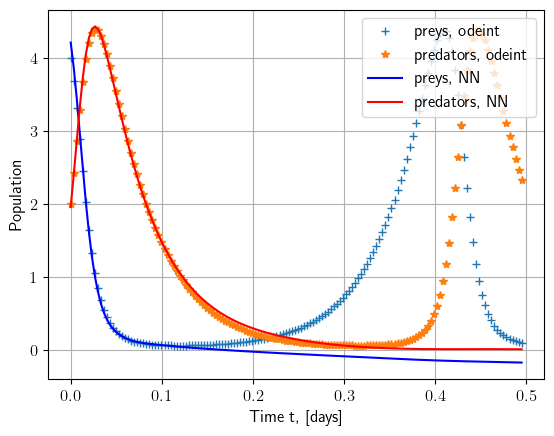

In [17]:
plt.plot(t_train, x, '+', label = 'preys, odeint')
plt.plot(t_train, y, '*', label = "predators, odeint")
plt.plot(t_train, pred_u_v[:, 0], color = 'b', label='preys, NN')
plt.plot(t_train, pred_u_v[:, 1], color = 'r', label='predators, NN')
plt.xlabel('Time t, [days]')
plt.ylabel('Population')
plt.grid()
plt.legend(loc='upper right')
plt.show()